In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import os
import shutil
import projcore as pc
from sklearn.impute import KNNImputer
from sklearn.manifold import MDS, TSNE
from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KernelDensity


sns.set(style="whitegrid")

In [2]:
source_dir = os.getcwd()
DATA_DIR = os.path.join(os.getcwd(), 'data')

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
    pc.download_kaggle_datasets()
    for file_name in os.listdir(source_dir):
        if file_name.endswith('.csv'):
            full_file_name = os.path.join(source_dir, file_name)
            if os.path.isfile(full_file_name):
                shutil.move(full_file_name, DATA_DIR)
                print(f"Moved: {full_file_name} to {DATA_DIR}")
else:
    print(f"Data directory already exists: {DATA_DIR}")

Data directory already exists: c:\Users\Saleh\Desktop\Clash-Royale-Causal-analysis\data


In [3]:
def load_data(data_dir=DATA_DIR):
    """Load all datasets."""
    battles_df = pd.read_csv(os.path.join(data_dir, 'BattlesStaging_01012021_WL_tagged.csv'))
    clash_royal_data = pd.read_csv(os.path.join(data_dir, 'clash_royal_data.csv'))
    card_master_list = pd.read_csv(os.path.join(data_dir, 'CardMasterListSeason18_12082020.csv'))
    wincons = pd.read_csv(os.path.join(data_dir, 'Wincons.csv'))
    
    mapping = {
        'battles_df': battles_df,
        'clash_royal_data': clash_royal_data,
        'card_master_list': card_master_list,
        'wincons': wincons
    }
    
    return mapping

In [4]:
# load the actual data
datasets_mapping = load_data()
battles_df = datasets_mapping['battles_df']
clash_royal_data = datasets_mapping['clash_royal_data']
card_master_list = datasets_mapping['card_master_list']
wincons = datasets_mapping['wincons']

In [5]:
battles_df = pc.feature_preprocessing(battles_df, wincons)

In [13]:
winner_decks = battles_df["winner.card_set"]
loser_decks = battles_df["loser.card_set"]

unique_winner_decks = winner_decks.unique()
num_unique_winner_decks = len(unique_winner_decks)
print(f"Number of unique winner decks: {num_unique_winner_decks}")
print("battles_df rows: ", battles_df.shape[0])
print("Ratio of unique winner decks to battles_df rows: ", num_unique_winner_decks / battles_df.shape[0])


Number of unique winner decks: 1292041
battles_df rows:  2823527
Ratio of unique winner decks to battles_df rows:  0.45759824503183427


In [14]:
def deck_to_sparse_vector(deck):
    """Convert a deck into a sparse binary vector."""
    indices = [card_to_index[card] for card in deck]
    vec = np.zeros(len(unique_cards), dtype=np.uint8)
    vec[indices] = 1
    return vec

deck_stats = {}
for deck in winner_decks:
    if deck not in deck_stats:
        deck_stats[deck] = {"wins": 0, "appearances": 0}
    deck_stats[deck]["wins"] += 1
    deck_stats[deck]["appearances"] += 1

for deck in loser_decks:
    if deck not in deck_stats:
        continue
    deck_stats[deck]["appearances"] += 1

deck_data = [
    {"Deck": deck, "Win Rate": stats["wins"] / stats["appearances"], "Appearances": stats["appearances"]}
    for deck, stats in deck_stats.items()
]
deck_df = pd.DataFrame(deck_data)
deck_df = deck_df.sort_values(by="Appearances", ascending=False)

unique_cards = sorted(set(card for deck in deck_df["Deck"] for card in deck))
card_to_index = {card: i for i, card in enumerate(unique_cards)}

battles_df_ext = battles_df.merge(deck_df[['Deck', 'Win Rate', 'Appearances']], left_on='winner.card_set', right_on='Deck', how='left')
battles_df_ext = battles_df_ext.rename(columns={'Win Rate': 'Win Rate', 'Appearances': 'Appearances'})
battles_df_ext = battles_df_ext.loc[:, ~battles_df_ext.columns.duplicated()]

battles_df_ext.head()

battleTime  arena.id  gameMode.id  average.startingTrophies  \
0 2020-12-31 21:02:12+00:00        13            0                  0.719960   
1 2020-12-31 21:02:15+00:00        13            0                  0.725893   
2 2020-12-31 21:02:45+00:00        13            0                  0.770937   
3 2020-12-31 21:03:13+00:00        13            0                  0.577546   
4 2020-12-31 21:03:17+00:00        13            0                  0.775725   

   winner.tag  winner.startingTrophies  winner.trophyChange  winner.crowns  \
0           0                 1.716736             1.473684            2.0   
1           1                 1.721694             1.491228            1.0   
2           2                 1.767252             1.473684            2.0   
3           3                 1.575238             1.473684            2.0   
4           4                 1.771808             1.473684            3.0   

   winner.kingTowerHitPoints  winner.princessTowersHitPoints  ...  \
0                     4145.0                            1484  ...   
1                     5304.0                            3661  ...   
2                     5762.0                            4179  ...   
3                     4392.0                            1322  ...   
4                     5832.0                            7336  ...   

   winner.min_card_level  winner.level_variance  \
0               1.000000               0.000000   
1               0.916667               0.007062   
2               1.000000               0.000000   
3               0.583333               0.030132   
4               1.000000               0.000000   

   winner.deck_weighted_strength  winner.elixir_score  loser.elixir_score  \
0                       1.000000             0.641489            0.855528   
1                       0.943182             0.457931            0.823688   
2                       1.000000             0.855528            0.933361   
3                       0.727273             0.666286            1.000000   
4                       1.000000             0.356637            0.666286   

   winner.synergy_score  winner.deck_final_score  \
0              0.611946                 0.889492   
1              0.629168                 0.821979   
2              0.628174                 0.933923   
3              0.586295                 0.719896   
4              0.611946                 0.832522   

                                                Deck  Win Rate  Appearances  
0  (26000003, 26000004, 26000006, 26000008, 26000...  0.648649           37  
1  (26000000, 26000010, 26000026, 26000040, 26000...  0.541099         2275  
2  (26000010, 26000042, 26000044, 26000055, 26000...  0.250000            4  
3  (26000016, 26000023, 26000026, 26000041, 28000...  0.462595          655  
4  (26000010, 26000014, 26000021, 26000030, 26000...  0.487398        67171  

[5 rows x 76 columns]

In [15]:
appearance_threshold = 19
winning_deck_threshold = 0.7
winner_df = battles_df_ext[(battles_df_ext["Appearances"] >= appearance_threshold) & (battles_df_ext["Win Rate"] >= winning_deck_threshold)].copy()
loser_df = battles_df_ext[(battles_df_ext["Appearances"] >= appearance_threshold) & (battles_df_ext["Win Rate"] < winning_deck_threshold)].copy()
scaler = MinMaxScaler()
winner_df.loc[:, "win_rate_scaled"] = scaler.fit_transform(winner_df["Win Rate"].values.reshape(-1, 1))

battles_df_ext = winner_df.copy()
print(f"Number of battles after filtering: {battles_df_ext.shape[0]}")

battles_df_ext.head()

Number of battles after filtering: 8433


battleTime  arena.id  gameMode.id  \
184 2020-12-31 21:17:19+00:00        13            0   
268 2020-12-31 21:20:18+00:00        13            0   
497 2020-12-31 21:26:40+00:00        13            0   
619 2020-12-31 21:29:53+00:00        13            0   
742 2020-12-31 21:32:40+00:00        13            0   

     average.startingTrophies  winner.tag  winner.startingTrophies  \
184                  0.680378         147                 1.674930   
268                  0.710722         207                 1.706686   
497                  0.690964         350                 1.686855   
619                  0.660553         419                 1.656036   
742                  0.711126         207                 1.706820   

     winner.trophyChange  winner.crowns  winner.kingTowerHitPoints  \
184             1.526316            2.0                     4279.0   
268             1.491228            3.0                     3161.0   
497             1.491228            1.0                     5832.0   
619             1.508772            2.0                     5755.0   
742             1.491228            3.0                     3062.0   

     winner.princessTowersHitPoints  ...  winner.level_variance  \
184                            3055  ...                    0.0   
268                            2141  ...                    0.0   
497                            3868  ...                    0.0   
619                            2013  ...                    0.0   
742                            2266  ...                    0.0   

     winner.deck_weighted_strength  winner.elixir_score  loser.elixir_score  \
184                            1.0             0.518904            0.726902   
268                            1.0             0.823688            0.587995   
497                            1.0             1.000000            1.000000   
619                            1.0             0.969440            1.000000   
742                            1.0             0.823688            0.356637   

     winner.synergy_score  winner.deck_final_score  \
184              0.611200                 0.864901   
268              0.609472                 0.925685   
497              0.625870                 0.962587   
619              0.609472                 0.954835   
742              0.609472                 0.925685   

                                                  Deck  Win Rate  Appearances  \
184  (26000014, 26000018, 26000030, 26000038, 26000...  0.703704           27   
268  (26000009, 26000015, 26000035, 26000039, 26000...  0.739130           23   
497  (26000004, 26000005, 26000011, 26000017, 26000...  0.736842           19   
619  (26000022, 26000028, 26000030, 26000032, 26000...  0.700000           40   
742  (26000009, 26000015, 26000035, 26000039, 26000...  0.739130           23   

     win_rate_scaled  
184         0.012346  
268         0.130435  
497         0.122807  
619         0.000000  
742         0.130435  

[5 rows x 77 columns]

In [16]:
selected_features = [
    # 'winner.card_set',
    'Deck',
    "winner.win_lose_ratio", "winner.tag", "winner.cards.list", "winner.win_lose_ratio_Z_score", 
    "Win Rate", "winner.deck_weighted_strength", "winner.rarity_diversity", "winner.synergy_score", "winner.deck_final_score",
]

battles_df_ext = battles_df_ext[selected_features]
# battles_df_ext = battles_df_ext.head(6000)

deck_vectors = np.array([deck_to_sparse_vector(deck) for deck in battles_df_ext["Deck"]])
deck_vectors_sparse = csr_matrix(deck_vectors)
deck_vectors_dense = deck_vectors_sparse.toarray()

In [17]:
# pairwise_dist = pairwise_distances(deck_vectors_dense, metric="hamming")
pairwise_dist = squareform(pdist(deck_vectors_dense, metric="hamming"))

In [18]:
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
deck_positions_mds = mds.fit_transform(pairwise_dist)

In [19]:

tsne = TSNE(n_components=2, metric="hamming", random_state=42, perplexity=30, n_jobs=-1)
deck_positions_tsne = tsne.fit_transform(deck_vectors_dense)

In [20]:
# battles_df_ext = battles_df_ext.loc[:, ~battles_df_ext.columns.duplicated()]

# battles_df_ext.head()

Skipping non-numeric feature: Deck


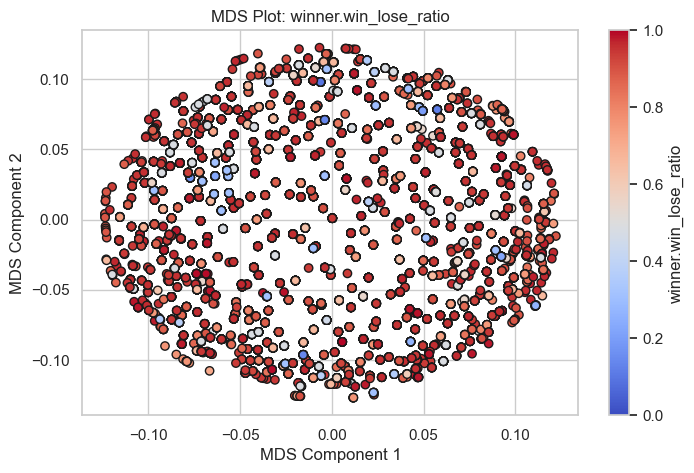

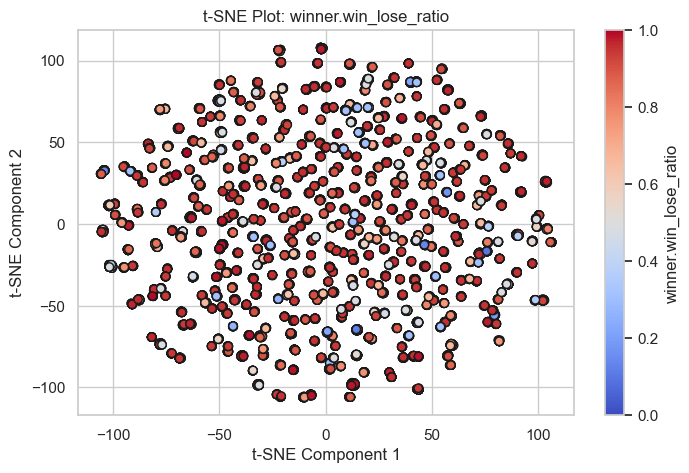

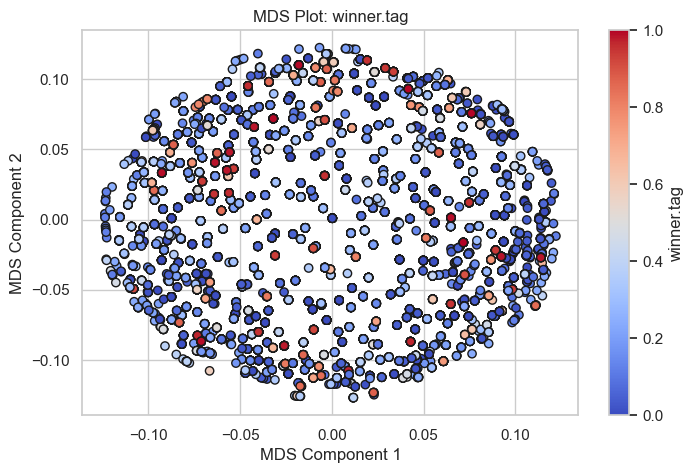

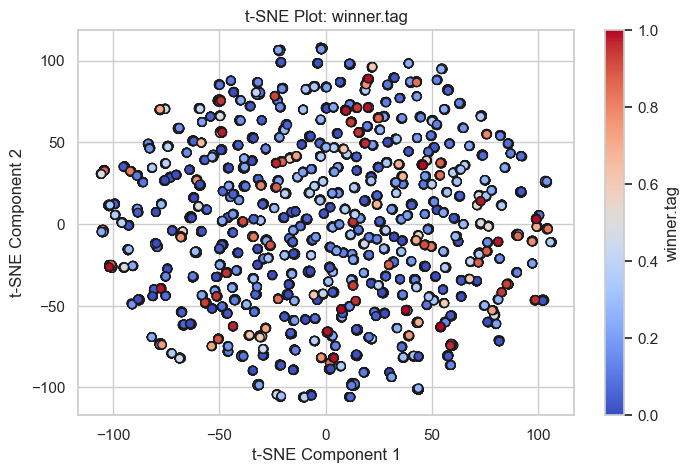

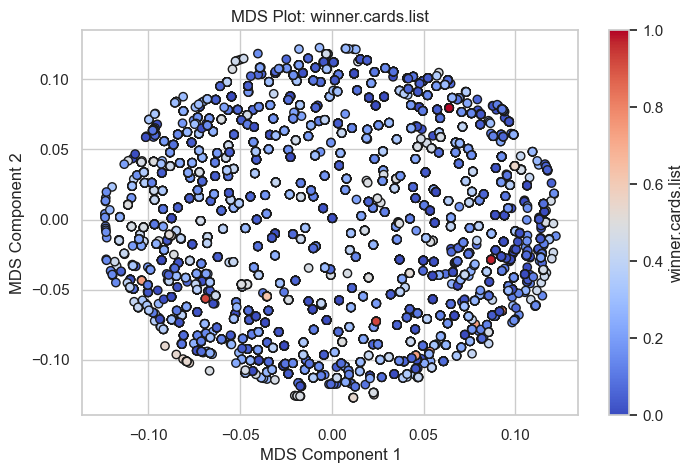

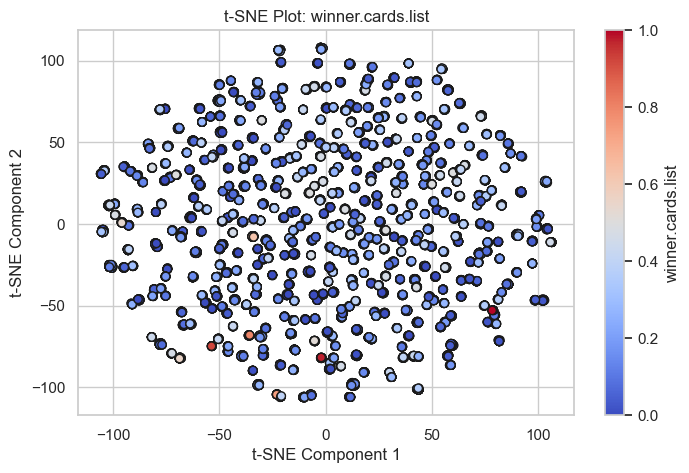

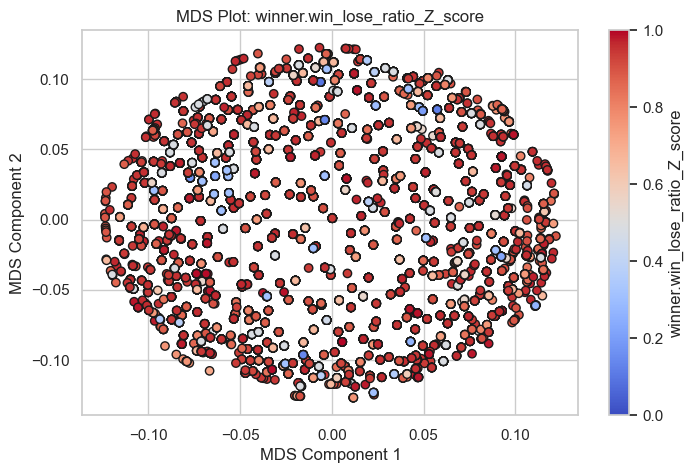

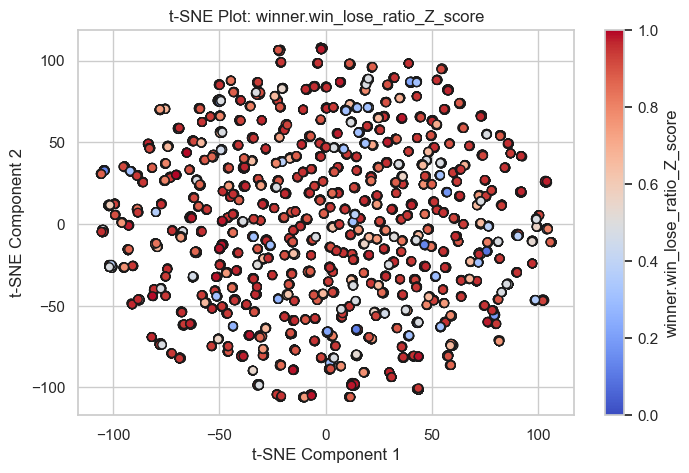

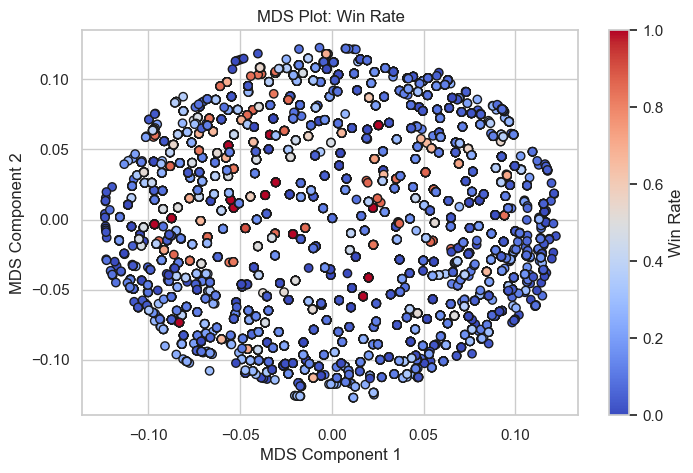

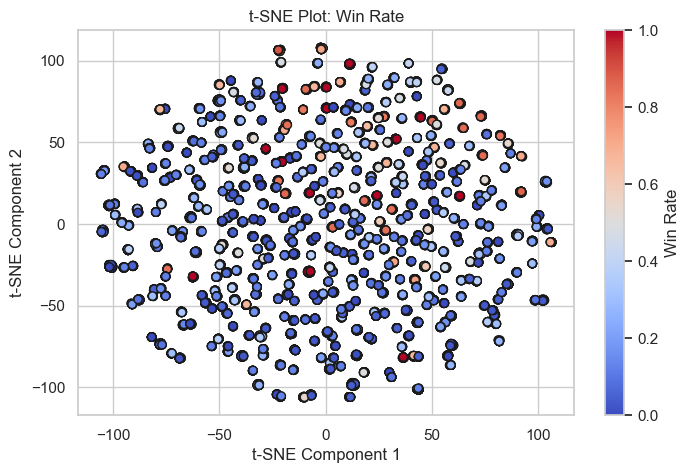

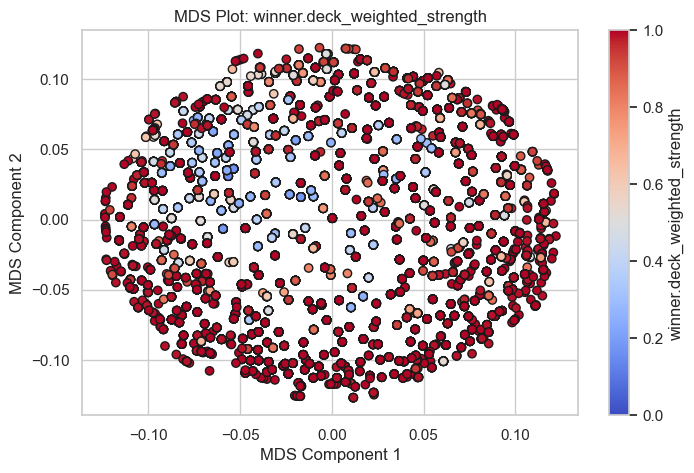

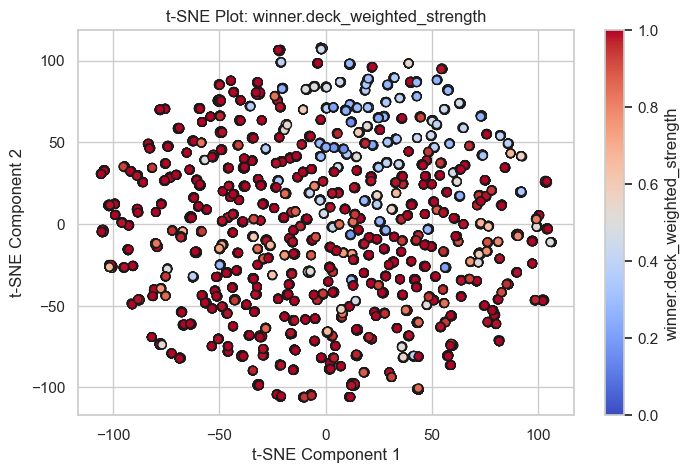

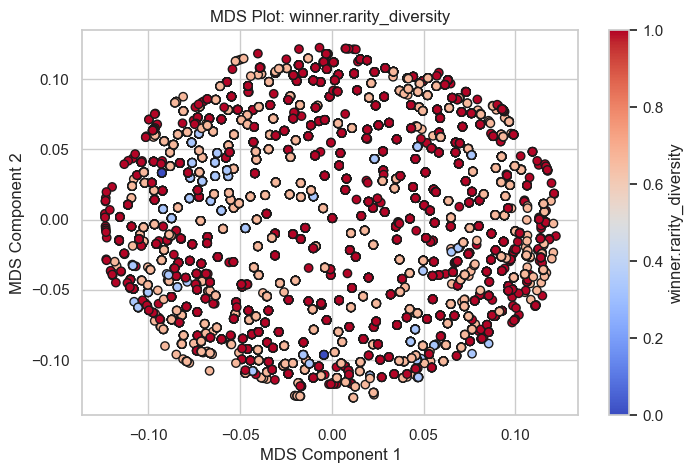

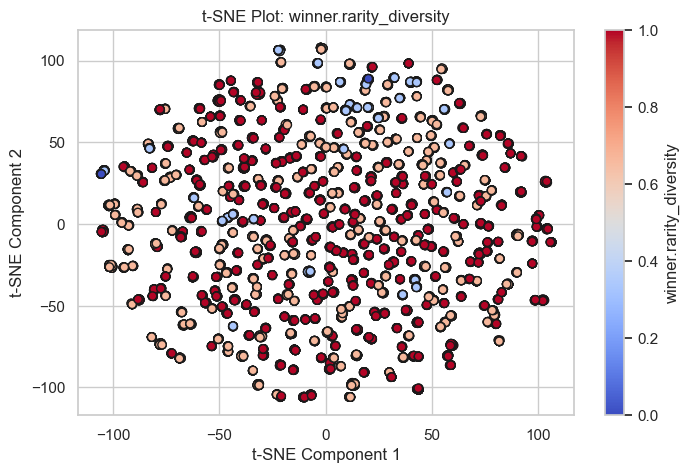

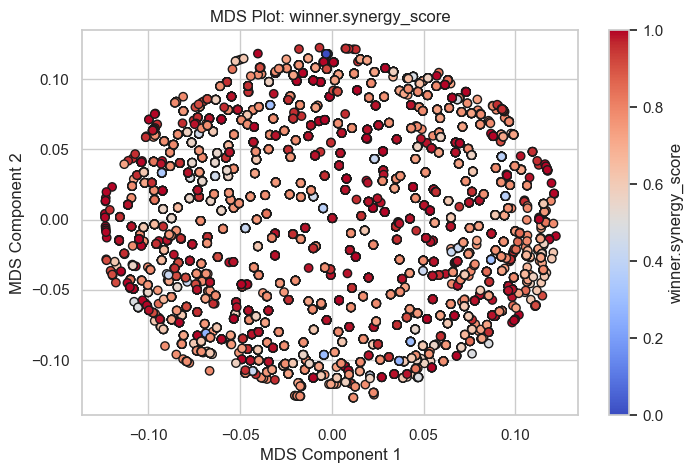

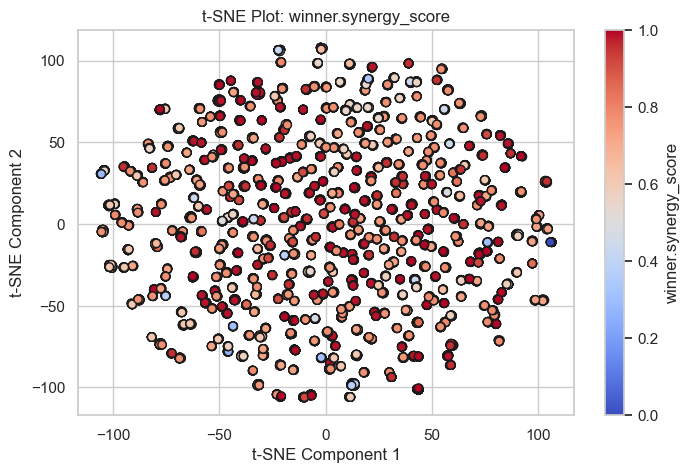

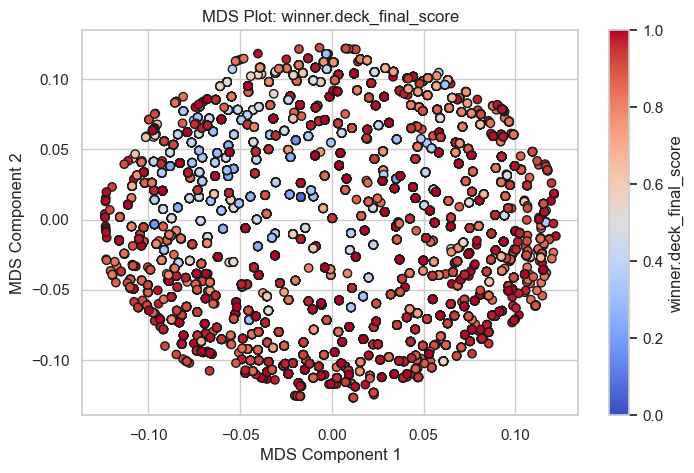

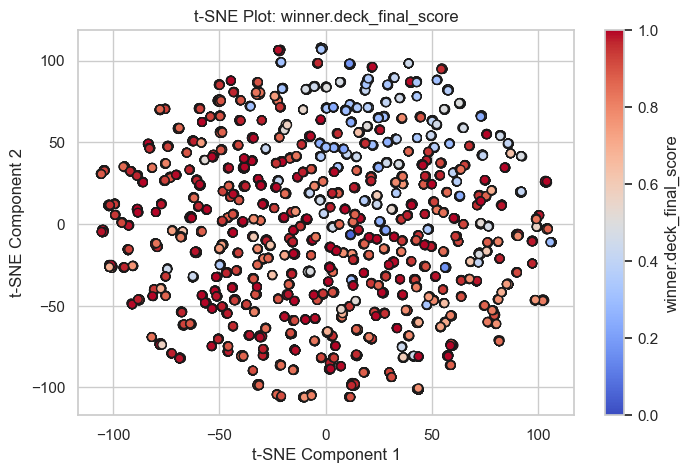

In [21]:
scaler = MinMaxScaler()

for feature in selected_features:
    if pd.api.types.is_numeric_dtype(battles_df_ext[feature]):
        feature_scaled = scaler.fit_transform(battles_df_ext[feature].values.reshape(-1, 1))

        plt.figure(figsize=(8, 5))
        plt.scatter(deck_positions_mds[:, 0], deck_positions_mds[:, 1], 
                    c=feature_scaled, cmap="coolwarm", edgecolors="k")
        plt.xlabel("MDS Component 1")
        plt.ylabel("MDS Component 2")
        plt.title(f"MDS Plot: {feature}")
        cbar = plt.colorbar()
        cbar.set_label(feature)
        plt.savefig(f"mds_plot_{feature}.png", dpi=300)
        plt.show()

        plt.figure(figsize=(8, 5))
        plt.scatter(deck_positions_tsne[:, 0], deck_positions_tsne[:, 1], 
                    c=feature_scaled, cmap="coolwarm", edgecolors="k")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.title(f"t-SNE Plot: {feature}")
        cbar = plt.colorbar()
        cbar.set_label(feature)
        plt.savefig(f"tsne_plot_{feature}.png", dpi=300)
        plt.show()
    else:
        print(f"Skipping non-numeric feature: {feature}")

C:\Users\Saleh\AppData\Local\Temp\ipykernel_25256\894170783.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_mds.tight_layout(rect=[0, 0, 0.9, 1])
C:\Users\Saleh\AppData\Local\Temp\ipykernel_25256\894170783.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_tsne.tight_layout(rect=[0, 0, 0.9, 1])


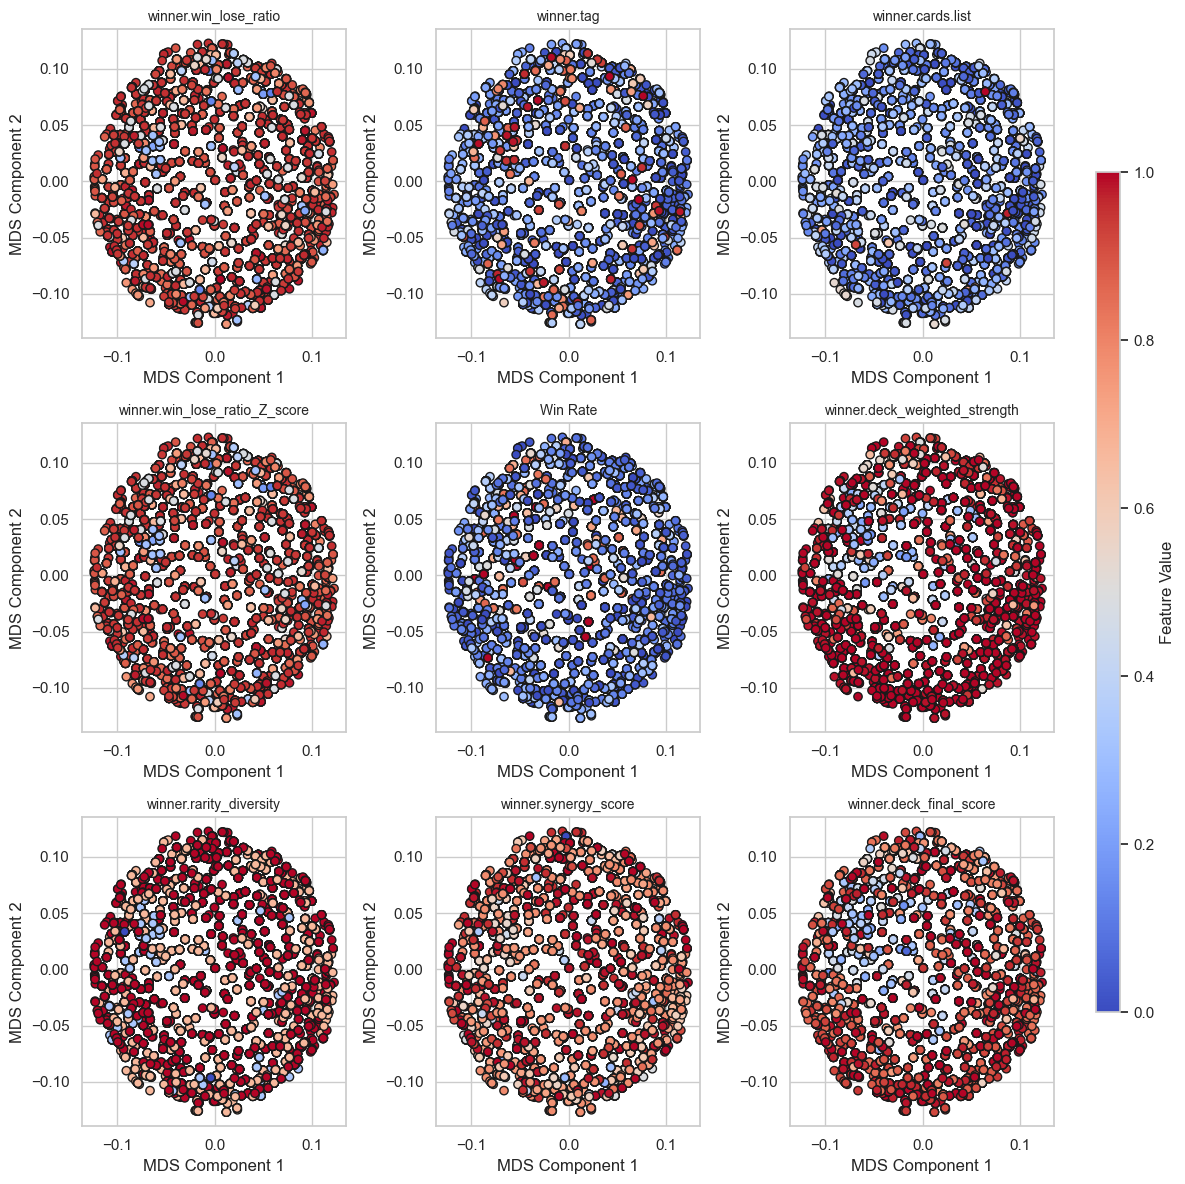

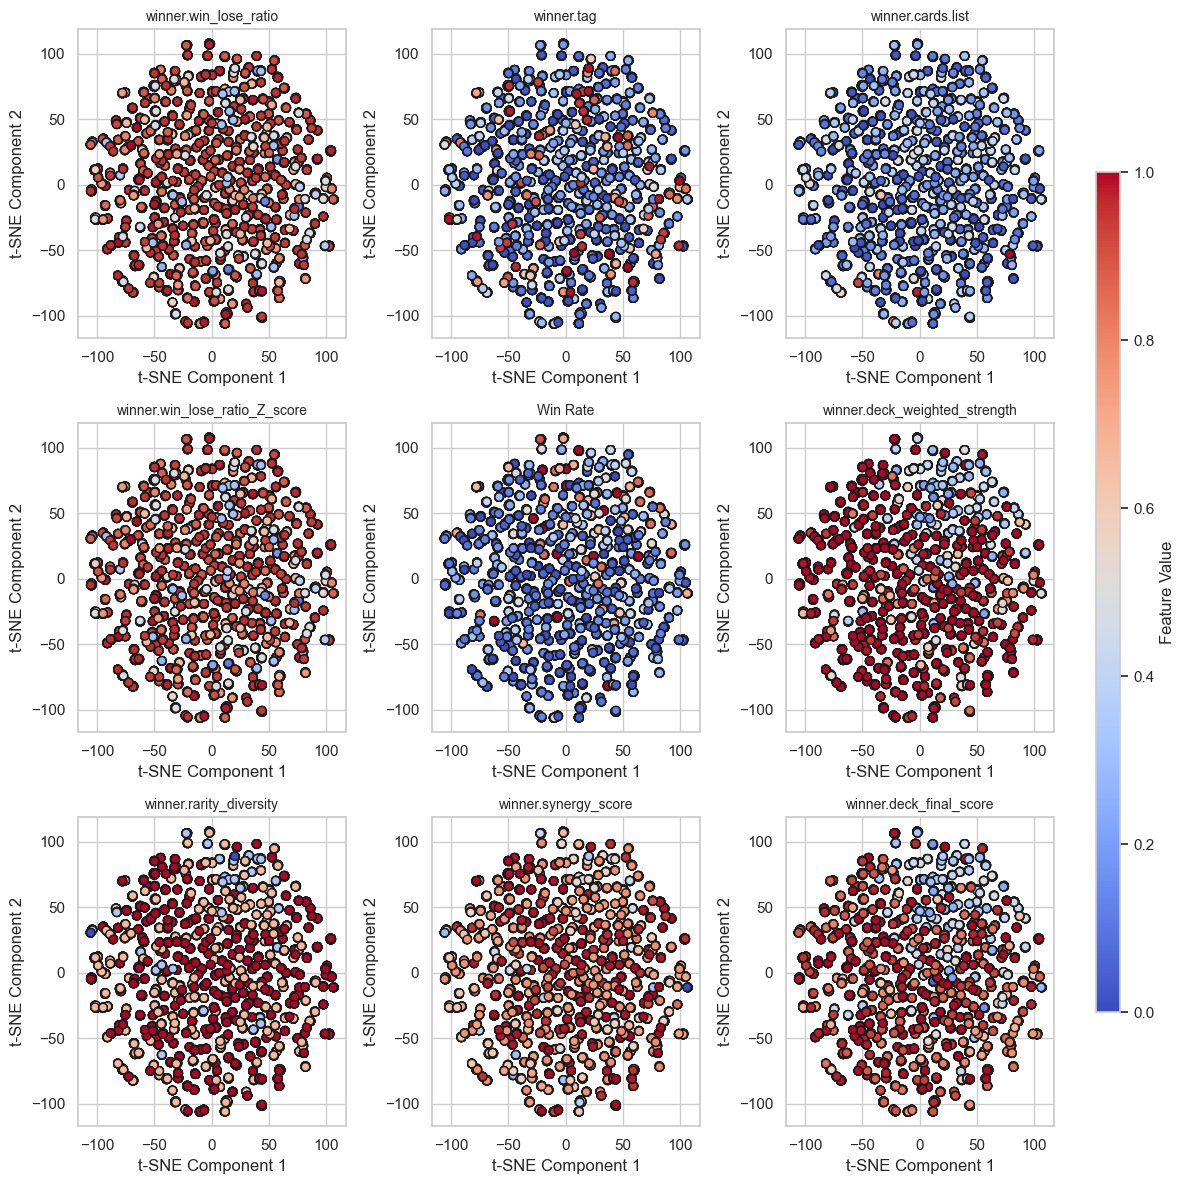

In [22]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np

scaler = MinMaxScaler()

numeric_features = [f for f in selected_features if pd.api.types.is_numeric_dtype(battles_df_ext[f])]
n_features = len(numeric_features)

n_cols = int(np.ceil(np.sqrt(n_features)))
n_rows = int(np.ceil(n_features / n_cols))  

fig_mds, axes_mds = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
fig_tsne, axes_tsne = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

axes_mds = axes_mds.flatten()
axes_tsne = axes_tsne.flatten()

sc_mds_first = None
sc_tsne_first = None

for i, feature in enumerate(numeric_features):
    feature_scaled = scaler.fit_transform(battles_df_ext[feature].values.reshape(-1, 1))

    # MDS Plot
    ax_mds = axes_mds[i]
    sc_mds = ax_mds.scatter(deck_positions_mds[:, 0], deck_positions_mds[:, 1], 
                            c=feature_scaled, cmap="coolwarm", edgecolors="k")
    ax_mds.set_xlabel("MDS Component 1")
    ax_mds.set_ylabel("MDS Component 2")
    ax_mds.set_title(f"{feature}", fontsize=10)

    if sc_mds_first is None:  
        sc_mds_first = sc_mds

    # t-SNE Plot
    ax_tsne = axes_tsne[i]
    sc_tsne = ax_tsne.scatter(deck_positions_tsne[:, 0], deck_positions_tsne[:, 1], 
                              c=feature_scaled, cmap="coolwarm", edgecolors="k")
    ax_tsne.set_xlabel("t-SNE Component 1")
    ax_tsne.set_ylabel("t-SNE Component 2")
    ax_tsne.set_title(f"{feature}", fontsize=10)

    if sc_tsne_first is None:  
        sc_tsne_first = sc_tsne

for j in range(i + 1, len(axes_mds)):
    fig_mds.delaxes(axes_mds[j])
    fig_tsne.delaxes(axes_tsne[j])

fig_mds.subplots_adjust(right=0.9)
cbar_ax_mds = fig_mds.add_axes([0.92, 0.15, 0.02, 0.7])
fig_mds.colorbar(sc_mds_first, cax=cbar_ax_mds, label="Feature Value")

fig_tsne.subplots_adjust(right=0.9)
cbar_ax_tsne = fig_tsne.add_axes([0.92, 0.15, 0.02, 0.7])
fig_tsne.colorbar(sc_tsne_first, cax=cbar_ax_tsne, label="Feature Value")

fig_mds.tight_layout(rect=[0, 0, 0.9, 1])
fig_mds.savefig("mds_plots.png", dpi=300)

fig_tsne.tight_layout(rect=[0, 0, 0.9, 1])
fig_tsne.savefig("tsne_plots.png", dpi=300)

plt.show()


# Initial Notes:
the plots here look a little more promising. some show signs of seperation between red and blue dots somehow

In [28]:
scaler = MinMaxScaler()
battles_df_ext["win_rate_scaled"] = scaler.fit_transform(battles_df_ext["Win Rate"].values.reshape(-1, 1))

battles_df_ext.head()

Deck  winner.win_lose_ratio  \
184  (26000014, 26000018, 26000030, 26000038, 26000...               0.900000   
268  (26000009, 26000015, 26000035, 26000039, 26000...               0.800000   
497  (26000004, 26000005, 26000011, 26000017, 26000...               0.518519   
619  (26000022, 26000028, 26000030, 26000032, 26000...               0.625000   
742  (26000009, 26000015, 26000035, 26000039, 26000...               0.800000   

     winner.tag  winner.cards.list  winner.win_lose_ratio_Z_score  Win Rate  \
184         147                140                       1.240341  0.703704   
268         207                187                       0.777609  0.739130   
497         350                306                      -0.524896  0.736842   
619         419                362                      -0.032172  0.700000   
742         207                187                       0.777609  0.739130   

     winner.deck_weighted_strength  winner.rarity_diversity  \
184                            1.0                        3   
268                            1.0                        3   
497                            1.0                        4   
619                            1.0                        3   
742                            1.0                        3   

     winner.synergy_score  winner.deck_final_score  win_rate_scaled  
184              0.611200                 0.864901         0.012346  
268              0.609472                 0.925685         0.130435  
497              0.625870                 0.962587         0.122807  
619              0.609472                 0.954835         0.000000  
742              0.609472                 0.925685         0.130435

In [29]:
pairwise_dist_jaccard = squareform(pdist(deck_vectors_dense, metric="jaccard"))

In [30]:
pairwise_dist_hamming = squareform(pdist(deck_vectors_dense, metric="hamming"))

In [31]:
pairwise_dist_cosine = squareform(pdist(deck_vectors_dense, metric="cosine"))

# Explanation:
below, we add some plots showing the results we receive for ['hamming', 'jaccard', 'cosine'] metrics. we mainly try to find ways of capturing similarities / differences between different decks in the game such that the separation is as good as possible when considering our data representation which is made of a vector the length of all the cards in the game with 1 in the corresponding index of each card that appears in the deck and 0 otherwise.

In order to capture those similarities between decks, we thought we'd use:
1. 'Hamming' distance
2. 'cosine' distance
3. 'jaccard' distance

# FOR PAPER
Below, we present plots showing the results for the \textbf{Hamming}, \textbf{Jaccard}, and \textbf{Cosine} distance metrics. Our primary objective is to measure similarity or dissimilarity between decks in a way that ensures meaningful separation, given our data representation. The decks are represented as binary vectors of length equal to the total number of cards in the game, where a \textbf{1} appears at the index of each card present in the deck and a \textbf{0} otherwise.

To quantify similarity between decks, we considered the following metrics:

\begin{enumerate}
    \item \textbf{Hamming Distance} – This metric measures the number of positions where two binary vectors differ. In our case, it counts the number of cards that are different between two decks. Since our representation is binary, Hamming distance is a simple and straightforward way to count how many cards are different between two decks. However, it does not take into account the total size of the decks, meaning that decks with different numbers of cards may not be well-differentiated (could happen with decks having the same card at different level).

    \item \textbf{Cosine Distance} – This metric measures the angle between two vectors in high-dimensional space. Since our vectors are binary, the cosine similarity effectively measures the fraction of shared cards between two decks relative to their total deck sizes. Cosine distance is useful when considering how much overlap two decks have while normalizing for deck size. However, it may be \textbf{less sensitive to small absolute differences} in decks that contain mostly similar cards.

    \item \textbf{Jaccard Distance} – This metric measures the proportion of non-shared elements relative to the total unique elements in two sets. It is computed as:

    \begin{equation}
        J(A, B) = 1 - \frac{|A \cap B|}{|A \cup B|}
    \end{equation}

    where \( A \) and \( B \) are two decks. Jaccard distance is particularly useful in this case because it \textbf{explicitly captures set-based similarity}, making it ideal for comparing deck compositions. However, it is \textbf{less effective when dealing with decks that have very different total card counts}, as it considers only presence or absence, not frequency or order.
\end{enumerate}

Thus, we selected \textbf{Hamming, Cosine, and Jaccard} because they each capture different aspects of deck similarity, providing a comprehensive view of how different decks relate to one another.


In [ ]:
from sklearn.manifold import MDS, TSNE
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import numpy as np

metrics = ["jaccard", "hamming", "cosine"]
plots_mds = {}
plots_tsne = {}

for metric in metrics:
    pairwise_dist_metric = squareform(pdist(deck_vectors_dense, metric=metric))
    
    # ---- MDS Visualization ----
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
    deck_positions_mds = mds.fit_transform(pairwise_dist_metric)
    plots_mds[metric] = deck_positions_mds

    plt.figure(figsize=(10, 6))
    sc = plt.scatter(deck_positions_mds[:, 0], deck_positions_mds[:, 1], 
                     c=deck_df["win_rate_scaled"], cmap="coolwarm", edgecolors="k")
    cbar = plt.colorbar(sc)
    cbar.set_label("Win Rate")
    plt.xlabel("MDS Component 1")
    plt.ylabel("MDS Component 2")
    plt.title(f"Deck Similarity (MDS - {metric} Distance)")
    plt.savefig(f"deck_similarity_mds_{metric}.png", dpi=300)
    plt.show()

    # ---- t-SNE Visualization ----
    tsne = TSNE(n_components=2, metric=metric, random_state=42)
    deck_positions_tsne = tsne.fit_transform(deck_vectors_dense)
    plots_tsne[metric] = deck_positions_tsne

    plt.figure(figsize=(10, 6))
    sc = plt.scatter(deck_positions_tsne[:, 0], deck_positions_tsne[:, 1], 
                     c=deck_df["win_rate_scaled"], cmap="coolwarm", edgecolors="k")
    cbar = plt.colorbar(sc)
    cbar.set_label("Win Rate")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(f"Deck Similarity (t-SNE - {metric} Distance)")
    plt.savefig(f"deck_similarity_tsne_{metric}.png", dpi=300)
    plt.show()

